In [1]:
import torch
import numpy
import pennylane as qml
import pennylane.numpy as np
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
def Cliff2():
    """
    Random 2-qubit Clifford circuit.

    Arguments:
        -nodes (np.ndarray): 
    
    Returns:
        -null
    """
    
    weights = np.random.randint(2, size=(2, 10))
    
    return qml.matrix(qml.RandomLayers(weights=weights,wires=[0,1])).numpy()

In [3]:
def RandomLayers(N_QUBITS, DEPTH):
    """
    Generates brick wall pattern of random 2 qubit Clifford gates

    Arguments:
        -N_QUBITS (int): Number of qubits
        -DEPTH (int): Depth of the circuit

    Returns:
        -random_layers (np.ndarray): Array of 4x4 unitaries (N_QUBITS, DEPTH, 4, 4)
    
    """

    random_layers = []
    for t in range(DEPTH):
        layer = []
        for x in range(0,N_QUBITS,2):
                layer.append(Cliff2())
        random_layers.append(layer)

    return random_layers


In [4]:
N_QUBITS = 2*2
DEPTH = 2

# random_layers = []
# # for t in range(DEPTH):
# #         layer = []
# #         for x in range(0,N_QUBITS,2):
# #                 layer.append(Cliff2())
# #         random_layers.append(layer)

random_layers = RandomLayers(N_QUBITS,DEPTH)

dev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(dev)
def circuit(theta,random_layers):
    """
    Quantum circuit with random entangling Clifford layers and disentangling layers.
    
    Arguments:
        -theta (np.ndarray): Binary matrix representing the positions of projections. (N_QUBITS, DEPTH)
    
    Returns:
        -Average Von Neumann entropy (float32): Average of 2-qubit Von Neumann entropies over all neighbors.
    """

    theta = theta.T
    DEPTH,N_QUBITS = np.shape(theta)

    for t in range(DEPTH):
        layer = random_layers[t]
        if t%2==0:
            for x in range(0,N_QUBITS,2):
                brick = layer[int(x/2)]
                qml.QubitUnitary(brick,wires=[x,x+1])
        elif t%2==1:
            for x in range(1,N_QUBITS-2,2):
                brick = layer[int((x-1)/2)]
                qml.QubitUnitary(brick,wires=[x,x+1])
            brick = layer[-1]
            qml.QubitUnitary(brick,wires=[N_QUBITS-1,0])
            
        projections = theta[t]
        for x in range(N_QUBITS):
            if projections[x]==1:
                qml.Projector(state=[0],wires=[x])
            
    entropies = []
    for x in range(N_QUBITS-1):
        entropies.append(qml.vn_entropy(wires=[x,x+1]))
    entropies.append(qml.vn_entropy(wires=[N_QUBITS-1,0]))
        
    return entropies

In [5]:
random_layers[1][0]

array([[-0.37656541-0.63776036j,  0.        +0.j        ,
        -0.45673878+0.49279803j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.59616361+0.18814922j,
         0.        +0.j        , -0.0719166 +0.77718519j],
       [-0.38262431-0.55232133j,  0.        +0.j        ,
         0.46279768-0.57823706j,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.18087327+0.75925864j,
         0.        +0.j        ,  0.56364588-0.27039693j]])

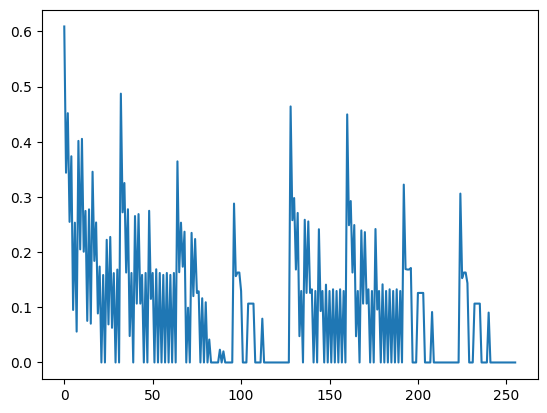

In [40]:
def all_binary_matrices(n, m):
    # Total number of binary matrices possible
    total_matrices = 2 ** (n * m)
    
    # Generate all binary matrices
    matrices = []
    for i in range(total_matrices):
        # Convert i to binary and pad with zeros
        binary_string = format(i, f'0{n*m}b')
        
        # Convert binary string to numpy array and reshape to (n, m)
        matrix = np.array([int(bit) for bit in binary_string]).reshape((n, m))
        matrices.append(matrix)
    
    return np.array(matrices)

x = all_binary_matrices(N_QUBITS,DEPTH)
Y = np.zeros(2**(N_QUBITS*DEPTH))
N = 100
for _ in range(N):
    random_layers = RandomLayers(N_QUBITS,DEPTH)
    y = [np.mean(circuit(theta,random_layers)) for theta in x]
    Y += y
Y = Y/N
plt.plot(Y)

In [67]:
min(Y)

tensor(-1.33226763e-17, requires_grad=True)

In [6]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
random_layers = RandomLayers(N_QUBITS,DEPTH)

circuit(theta,random_layers)
drawer = qml.draw(circuit)
print(drawer(theta,random_layers))

0: ─╭U(M0)──|0⟩⟨0|─╭U(M3)─────────┤ ╭vnentropy                       ╭vnentropy
1: ─╰U(M0)─╭U(M2)──│──────────────┤ ╰vnentropy ╭vnentropy            │         
2: ─╭U(M1)─╰U(M2)──│───────|0⟩⟨0|─┤            ╰vnentropy ╭vnentropy │         
3: ─╰U(M1)──|0⟩⟨0|─╰U(M3)─────────┤                       ╰vnentropy ╰vnentropy

M0 = 
[[-0.38559668-0.04028847j  0.20719939-0.29245522j -0.04209668+0.68875518j
   0.41325937+0.27256424j]
 [ 0.1185283 -0.34776932j  0.40271743-0.39624278j  0.54786814-0.29111321j
  -0.11759264+0.3835146j ]
 [ 0.06711949-0.78663439j -0.45878245-0.013435j    0.11794004+0.28637914j
  -0.09608053-0.24674914j]
 [ 0.22246317-0.20472185j  0.09400878+0.57693084j  0.15093121-0.14224866j
   0.71066915+0.1372833j ]]
M1 = 
[[-0.15078206+0.09240569j  0.2641283 -0.4490937j   0.01808196+0.78901126j
   0.03237067+0.27085691j]
 [ 0.2961292 -0.12662835j  0.54889994-0.14156597j  0.29684084-0.39245192j
  -0.08112386+0.57116251j]
 [-0.10905544-0.91684546j  0.00245735+0.07662997j  0.2577220

In [28]:
def loss(theta, random_layers,alpha=1, beta=0.1, gamma=0.5):
    entropy = alpha*np.mean(circuit(theta,random_layers))
    budget = beta*np.mean(np.ndarray.flatten(theta))
    final_layer = gamma*np.mean(theta[:,-1])
    
    return entropy+budget

In [29]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
loss(theta,random_layers)

tensor(0.11469919, requires_grad=True)

In [30]:
def grad(theta,random_layers):
    grads = np.zeros(np.shape(theta))

    for i in range(np.shape(theta)[0]):
        for j in range(np.shape(theta)[1]):
            h = np.zeros(np.shape(theta))
            h[i][j] = 1
            theta_prime = (theta+h)%2
            grads[i][j] = loss(theta_prime,random_layers) - loss(theta,random_layers)
    
    return grads
    

In [31]:
theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
random_layers = RandomLayers(N_QUBITS,DEPTH)
grad(theta,random_layers)

tensor([[-0.0125, -0.0125],
        [-0.0125, -0.0125],
        [-0.0125, -0.0125],
        [ 0.0125, -0.0125]], requires_grad=True)

In [32]:
np.unravel_index(np.argmin(grad(theta,random_layers)), shape=np.shape(theta))

(0, 0)

In [33]:
def main():
    n_training = 10
    random_layers = RandomLayers(N_QUBITS,DEPTH)
    theta = np.random.randint(2, size=(N_QUBITS,DEPTH))
    for step in range(n_training):
        l = loss(theta,random_layers)
        entropy = np.mean(circuit(theta,random_layers))
        g = grad(theta,random_layers)
        dir = np.unravel_index(np.argmin(grad(theta,random_layers)), shape=np.shape(theta))
        h = np.zeros(np.shape(theta))
        h[dir[0]][dir[1]] = 1
        theta = (theta+h)%2


    return theta, l, entropy


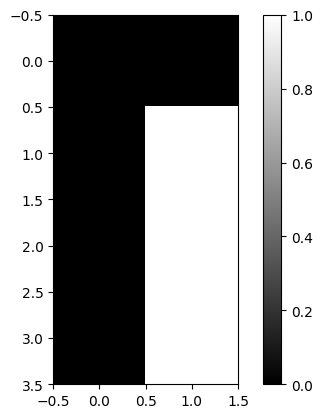


 Loss: 0.04999999999999978, 


In [34]:
theta, l, entropy = main()
plt.imshow(theta, cmap="gray")
plt.colorbar()
plt.show()
print("\n Loss: {}, \n Averaged von Neumann entropy: {}".format(l, entropy), end="\r")

In [35]:
epochs = 10
thetas = []
losses = []
entropies = []
for epoch in range(epochs):
    theta, l, entropies = main()
    thetas.append(theta)
    losses.append(l)

    print("\n Epoch: {}, Loss: {}".format(epoch+1, l), end="\r")


 Epoch: 1, Loss: 0.03750000000000033
 Epoch: 2, Loss: 0.03749999999999981
 Epoch: 3, Loss: 0.05
 Epoch: 4, Loss: 0.05
 Epoch: 5, Loss: 0.03750000000000029
 Epoch: 6, Loss: 0.037499999999999784
 Epoch: 7, Loss: 0.037499999999999784
 Epoch: 8, Loss: 0.04999999999999978
 Epoch: 9, Loss: 0.03977250604951253


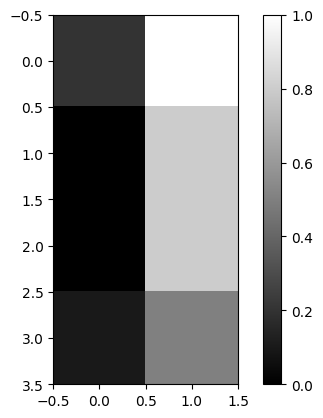

In [36]:
averaged_measurements = np.mean(thetas, axis=0)
plt.imshow(averaged_measurements, cmap="gray")
plt.colorbar()
plt.show()

In [38]:
for theta in thetas:
    print(np.mean(circuit(theta,random_layers)))

0.0
1.3078666009050044e-15
9.257780586166214e-16
9.257780586166214e-16
3.554081935051862e-16
7.669529059120653e-17
0.0
9.257780586166214e-16
9.257780586166214e-16
2.266320285367133e-15


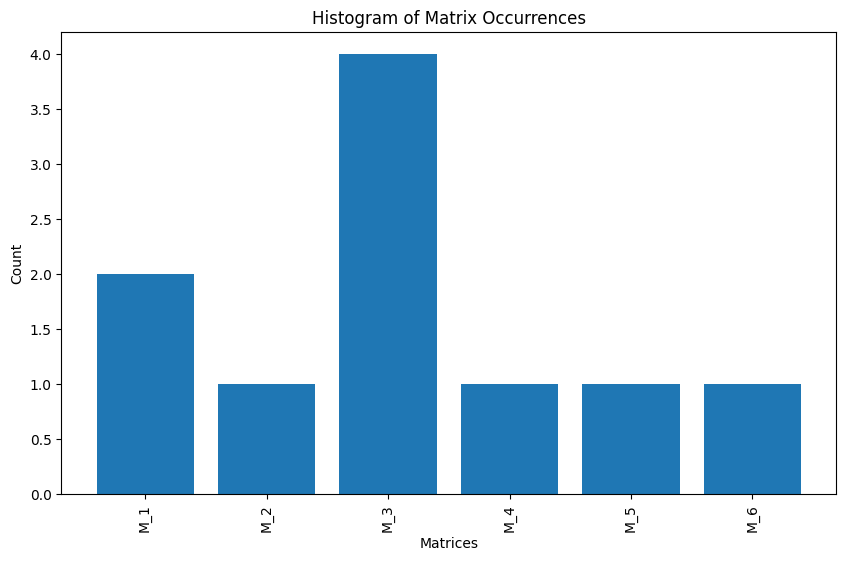

In [39]:
hashable_matrices = [tuple(map(tuple, matrix)) for matrix in thetas]

matrix_counts = Counter(hashable_matrices)

labels, counts = zip(*matrix_counts.items())

labels = [np.array(label) for label in labels]

plt.figure(figsize=(10,6))
plt.bar(range(len(counts)), counts, tick_label=["M_"+str(i+1) for i in range(len(labels))])
plt.xlabel('Matrices')
plt.ylabel('Count')
plt.title('Histogram of Matrix Occurrences')
plt.xticks(rotation=90)
plt.show()